In [1]:
%matplotlib inline
from helperFunctions import *
from constants import *
from dataAnalysisFunctions import getSEM, getCleanedSignal, getIntervals, getPowerRatio
import pandas as pd

from featureBuilder import featureBuilder

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Import svm model
from sklearn import svm


## Build dataframes and variables needed

In [3]:
# Load datas and concat into one dataframe 
# Load dataset 1
foldername='P001'
filename='part_P001_block_S004'
#filtered_data = loadData(datatype='filtered_data', foldername=foldername, filename=filename)
#filtered_cleaned_data = loadData(datatype='filtered_cleaned_data', foldername=foldername, filename=filename)
df1 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

# Load dataset 2
foldername='P001'
filename='part_P001_block_S005'
df2 = loadData(datatype='dataframe', foldername=foldername, filename=filename)

df = pd.concat([df1, df2], ignore_index=True)

In [4]:
# Select the trials needed to classify
focused_state = df["trial_time"] == 0.7
unfocused_state = df["trial_time"] > 0.9

focused_df = df[focused_state]
unfocused_df = df[unfocused_state]

num_to_keep = min(len(focused_df), len(unfocused_df))

focused_df = focused_df.drop(focused_df.sample(len(focused_df) - num_to_keep).index)
unfocused_df = unfocused_df.drop(unfocused_df.sample(len(unfocused_df) - num_to_keep).index)

print("focused len:", len(focused_df), "unfocused len:", len(unfocused_df))


focused len: 420 unfocused len: 420


In [12]:
focused_df.head() 

,data_index,data,data_extended,is_target,is_pressed,has_letters_shown,has_meme,time,points,reaction_time,section_number,looking_up,looking_right,trial_time,word_length
19,19,"{'aux': {'time': [1007.7778822847457, 1007.778...","{'aux': {'time': [1007.2824752964111, 1007.282...",False,False,False,False,1007.776022,0,0.000000,1,0,0,0.7,5
20,20,"{'aux': {'time': [1008.4988885828665, 1008.499...","{'aux': {'time': [1007.9963025225705, 1007.996...",True,True,False,False,1008.492069,1,0.000000,1,0,0,0.7,2
21,21,"{'aux': {'time': [1009.2114799770327, 1009.211...","{'aux': {'time': [1008.7161990336974, 1008.716...",True,True,False,False,1009.209934,2,0.455383,1,0,0,0.7,6
22,22,"{'aux': {'time': [1009.9334808081481, 1009.933...","{'aux': {'time': [1009.4299002968575, 1009.430...",True,True,False,False,1009.928703,1,0.681976,1,0,0,0.7,11
23,23,"{'aux': {'time': [1010.6529337472773, 1010.653...","{'aux': {'time': [1010.1502933399815, 1010.150...",False,False,False,False,1010.649533,0,0.000000,1,0,0,0.7,9


In [11]:
unfocused_df.head()

,data_index,data,data_extended,is_target,is_pressed,has_letters_shown,has_meme,time,points,reaction_time,section_number,looking_up,looking_right,trial_time,word_length
0,0,"{'aux': {'time': [988.999909591776, 989.000117...","{'aux': {'time': [988.4972506704805, 988.49752...",True,False,False,False,988.995118,-1,0.000000,1,0,0,1.0,8
1,1,"{'aux': {'time': [990.0137349623215, 990.01392...","{'aux': {'time': [989.5172514059926, 989.51752...",True,True,False,False,990.011403,1,0.140599,1,0,0,1.0,6
3,3,"{'aux': {'time': [992.0462132503861, 992.05411...","{'aux': {'time': [991.5444450500859, 991.54470...",False,False,False,False,992.039946,0,0.000000,1,0,0,1.0,4
7,7,"{'aux': {'time': [996.0840825256614, 996.08431...","{'aux': {'time': [995.5820637633624, 995.58242...",False,False,False,False,996.081942,0,0.000000,1,0,0,1.0,4
9,9,"{'aux': {'time': [998.1116362807527, 998.11788...","{'aux': {'time': [997.6089713164571, 997.60924...",True,False,False,False,998.108051,-1,0.000000,1,0,0,1.0,7


In [71]:
# Create the dataframes
fb = featureBuilder()
dictionary = {}
for row_index,row in unfocused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=0, dictionary=dictionary)
for row_index,row in focused_df.iterrows():
    dictionary = fb.appendDataToDict(row["data_extended"], focused=2, dictionary=dictionary)

# for row_index,row in med_df.iterrows():
#     dictionary = fb.appendDataToDict(row["data_extended"], focused=1, dictionary=dictionary)
#del dictionary['average norm_mean_first_difference']
#del dictionary['average norm_mean_second_difference']
keywords_to_keep = ['delta', 'theta', 'alpha', 'beta', 'focused']
dkeys = list(dictionary.keys())
for key in dkeys: 
    if not any(word in key for word in keywords_to_keep):
        del dictionary[key]
        
feature_df = pd.DataFrame(dictionary)
len(feature_df)

840

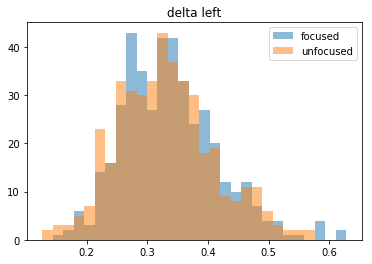

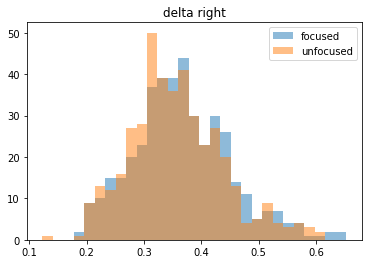

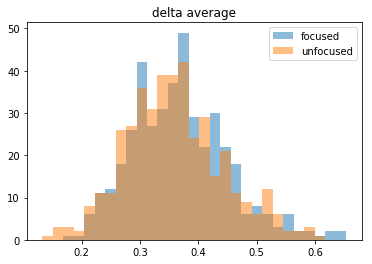

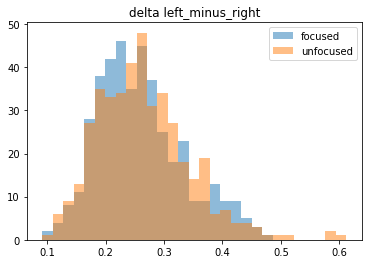

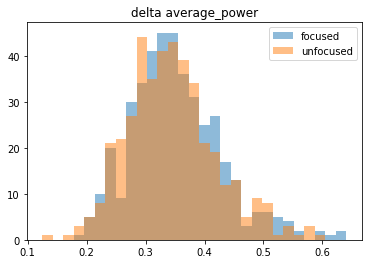

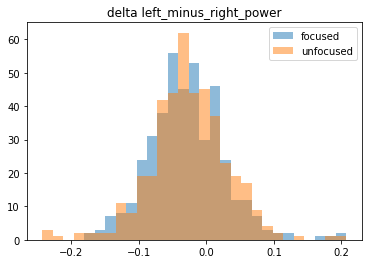

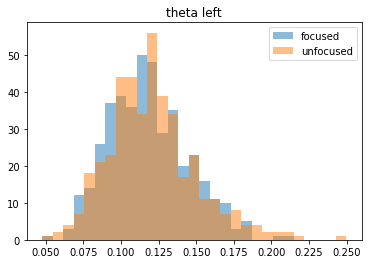

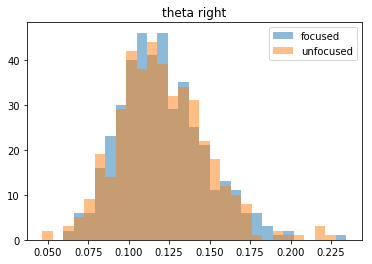

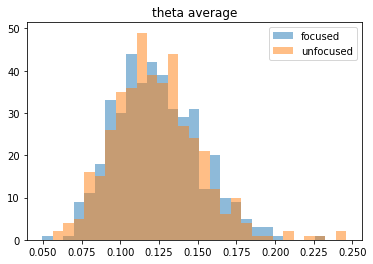

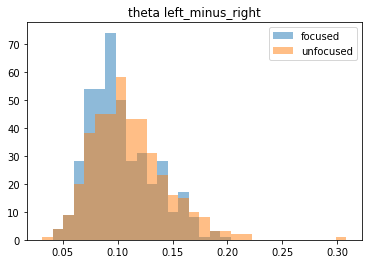

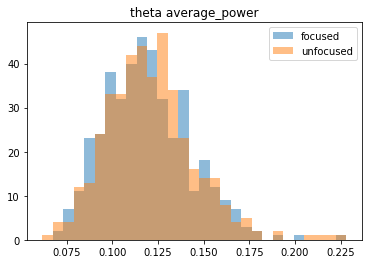

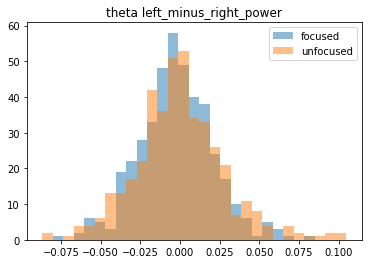

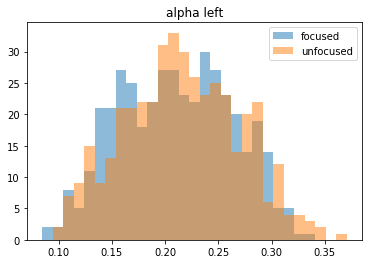

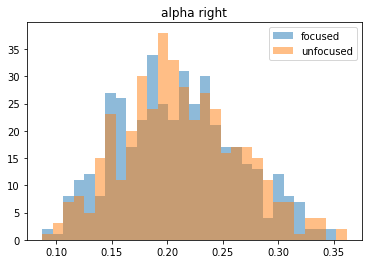

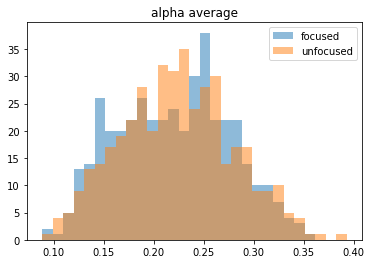

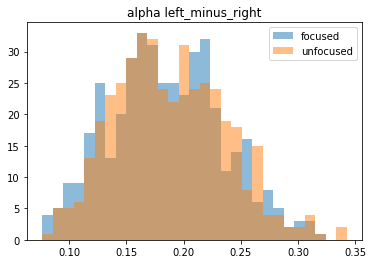

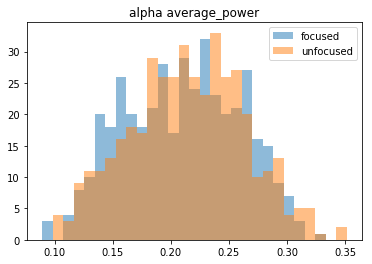

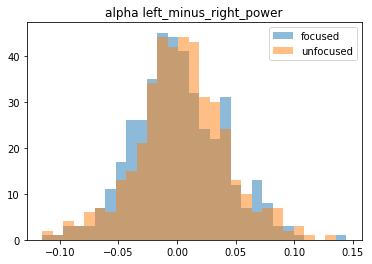

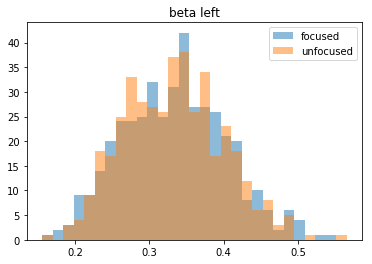

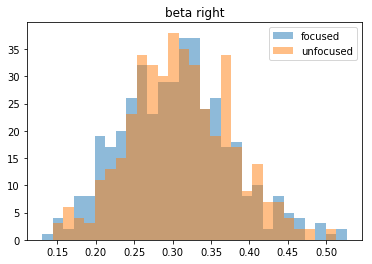

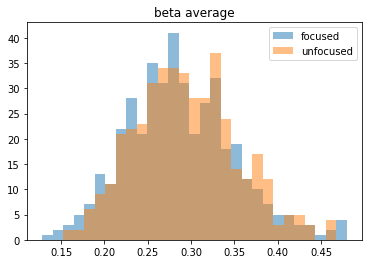

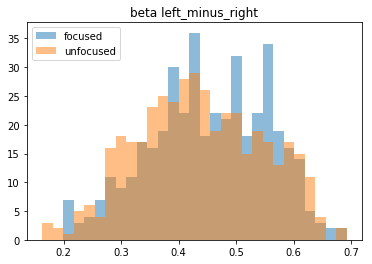

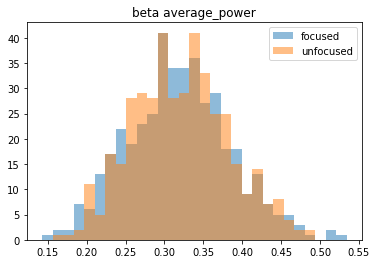

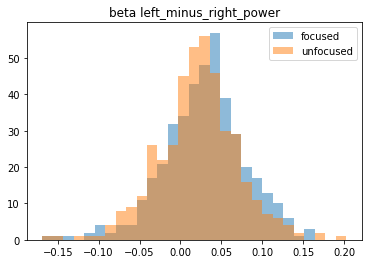

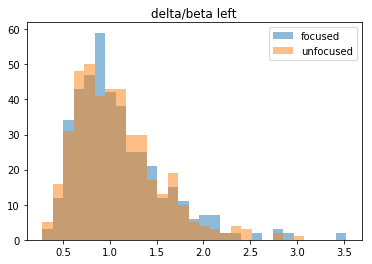

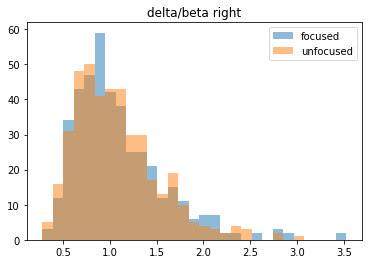

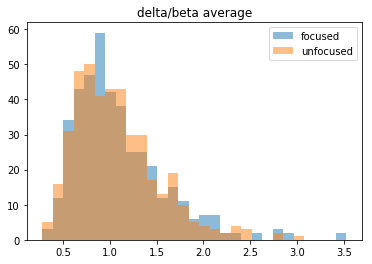

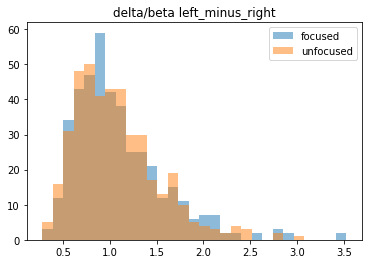

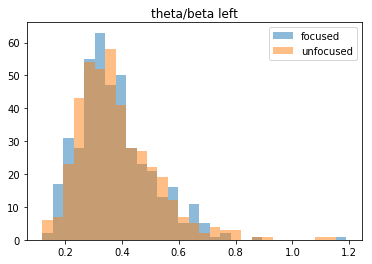

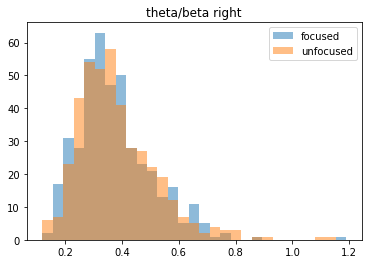

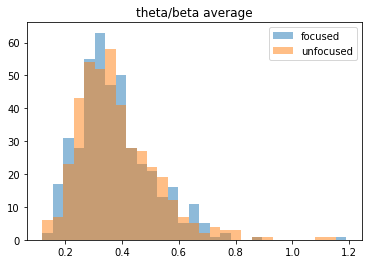

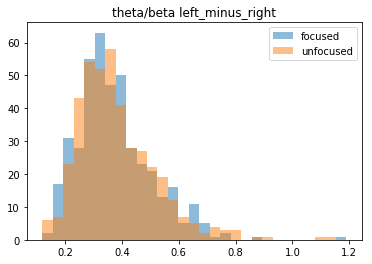

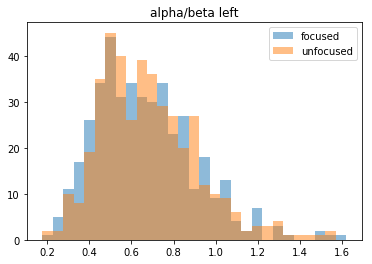

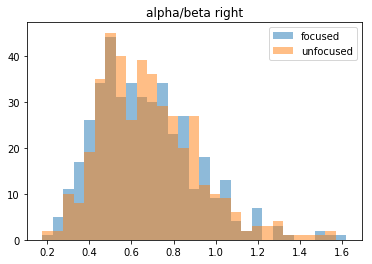

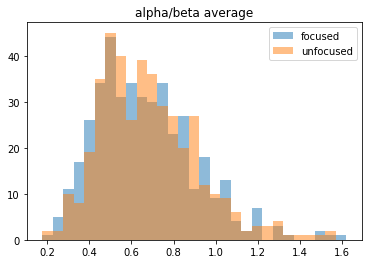

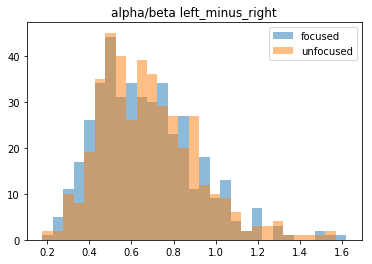

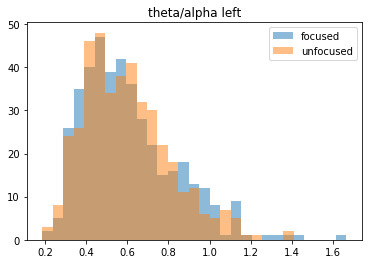

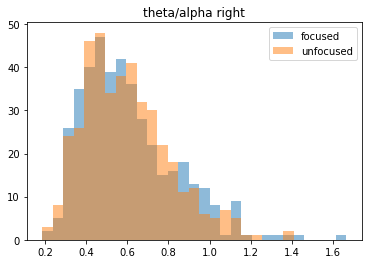

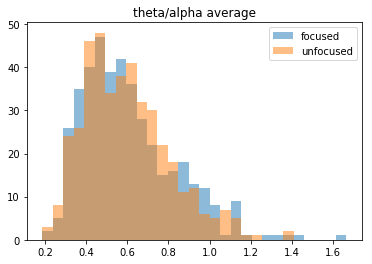

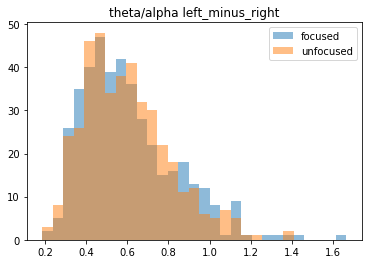

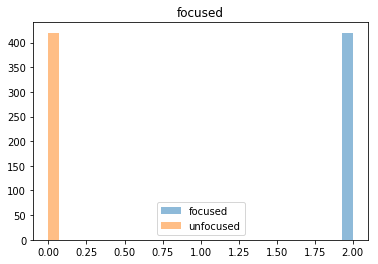

In [78]:
for col in feature_df.columns: 
    full_data = feature_df[col].values
    bins = np.linspace(min(full_data), max(full_data), 30)
    
    data = feature_df[feature_df['focused'] == 2][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="focused") 
    
    data = feature_df[feature_df['focused'] == 0][col].values
    plt.hist(data, bins=bins, alpha=0.5, label="unfocused") 
    
    
    
    plt.title(col)
    plt.legend()
    plt.show()

In [73]:
# Needed for visualizing LDA components
colors=['blue', 'orange', 'green']
class_names=["unfocused", "mid_focused", "focused"]

## LDA using sklearn 1 dim (2 possible outputs)
https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [75]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using random forest classifier
    classifier = RandomForestClassifier(max_depth=2, random_state=0)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + Random Forest accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.6011904761904762
Accuracy 0.5773809523809523
Accuracy 0.5416666666666666
Accuracy 0.6488095238095238
Accuracy 0.5892857142857143
Accuracy 0.5416666666666666
Accuracy 0.5833333333333334
Accuracy 0.5952380952380952
Accuracy 0.6071428571428571
Accuracy 0.6130952380952381
Avg LDA + Random Forest accuracy: 0.5898809523809523


In [26]:
X_train.shape

(672, 1)

## LDA w/ SVM Classifier
https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

In [76]:
# Average the accuracy over X different random samples
accuracies = []
for rand_state_var in range(10): 
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(feature_df.drop(columns=["focused"]), feature_df["focused"], test_size=0.2, random_state=rand_state_var)

    lda = LinearDiscriminantAnalysis(n_components=1)
    features_wo_output = feature_df.drop(columns=["focused"])
    X_train, scaler = scaleData(X_train, X_train.columns.values) # Scaling doesn't change anything
    X_test = scaler.transform(X_test)
    X_train = lda.fit_transform(X_train, y_train)
    X_test = lda.transform(X_test)


    ## Classify using SVM
    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    # Report accuracy
    #cm = confusion_matrix(y_test, y_pred)
    #print(cm)
    print('Accuracy', str(accuracy_score(y_test, y_pred)))
    accuracies.append(accuracy_score(y_test, y_pred))
print("Avg LDA + SVM accuracy:", np.mean(np.array(accuracies)))

Accuracy 0.5892857142857143
Accuracy 0.5833333333333334
Accuracy 0.5535714285714286
Accuracy 0.6547619047619048
Accuracy 0.5773809523809523
Accuracy 0.5654761904761905
Accuracy 0.5714285714285714
Accuracy 0.6011904761904762
Accuracy 0.5773809523809523
Accuracy 0.6071428571428571
Avg LDA + SVM accuracy: 0.588095238095238


In [19]:
zipped_list = list(zip(lda.coef_[0], feature_df.drop(columns="focused").columns))
sorted_zip_list = sorted(zipped_list)
sorted_zip_list

[(-15.445566816728812, 'left norm_mean_first_difference'),
 (-14.001866136527894, 'left_minus_right mean_second_difference'),
 (-12.375714961258804, 'left std_voltage'),
 (-10.102473509509984, 'right std_voltage'),
 (-9.391113621570735, 'right norm_mean_second_difference'),
 (-7.69071444557099, 'beta average'),
 (-7.671010731530231, 'left mean_second_difference'),
 (-4.304717774609645, 'alpha average_power'),
 (-4.148189663882228, 'alpha left'),
 (-3.5003405823529907, 'alpha right'),
 (-3.0065187049488467, 'average mean_second_difference'),
 (-2.8499015460839825, 'right mean_first_difference'),
 (-2.2344173579931725, 'beta left_minus_right'),
 (-1.8735327965305366, 'delta average'),
 (-1.749200486833138, 'theta left'),
 (-1.667172169473199, 'left_minus_right std_voltage'),
 (-1.5974549348473763, 'theta average_power'),
 (-1.5068097309658666, 'alpha left_minus_right_power'),
 (-1.0233832273315377, 'theta right'),
 (-0.9238304178853349, 'theta left_minus_right_power'),
 (-0.6627183504899

LDA explained variance: [1.]


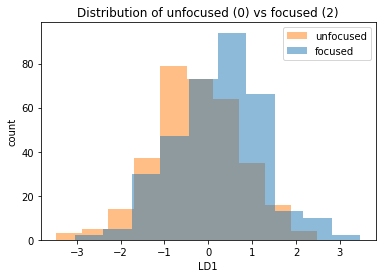

In [82]:
# Visualize LDA model 

class_names={2:"focused", 0:"unfocused"}
colors={2:"C0", 0:"C1"}

print("LDA explained variance:", lda.explained_variance_ratio_)

# Create dataframe for the feature
lda_feature_df = pd.DataFrame(X_train, columns=['LDA 1'])
lda_feature_df['focused']=y_train.values

# Plot groups wrt LDA 1 dimension

for class_name, df in lda_feature_df.groupby('focused'): 
    plt.hist(df['LDA 1'].values, alpha=0.5, color=colors[class_name], label=class_names[class_name])

plt.xlabel('LD1')
plt.ylabel("count")
plt.title("Distribution of unfocused (0) vs focused (2)")    
plt.legend()
plt.show()

## LDA manual

In [ ]:
class_feature_means = pd.DataFrame(columns=[False,True])
for class_name, rows in feature_df.groupby('focused'):
    class_feature_means[class_name] = rows.mean()
    
class_feature_means = class_feature_means.drop(['focused'])

In [ ]:
num_features = len(class_feature_means)
within_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    s = np.zeros((num_features, num_features))
    for index, row in rows.iterrows():
        x, mc = row.values.reshape(num_features, 1), class_feature_means[c].values.reshape(num_features, 1)
        s += (x-mc).dot((x-mc).T)
    within_class_scatter_matrix += s


In [ ]:
feature_means = feature_df.mean().drop(['focused'])
between_class_scatter_matrix = np.zeros((num_features, num_features))
for c,rows in feature_df.groupby('focused'):
    rows=rows.drop(columns=['focused'])
    n = len(rows)
    mc, m = class_feature_means[c].values.reshape(num_features, 1), feature_means.values.reshape(num_features, 1)
    between_class_scatter_matrix += n*(mc - m).dot((mc - m).T)

In [ ]:
within_class_scatter_matrix.shape

In [ ]:
between_class_scatter_matrix.shape

In [ ]:
inv_within_class_scatter_matrix = np.linalg.pinv(within_class_scatter_matrix)

In [ ]:
eigen_values, eigen_vectors = np.linalg.eig(inv_within_class_scatter_matrix.dot(between_class_scatter_matrix))


In [ ]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
print("top 10 eigenvalues")
for pair in pairs[:10]:
    print(pair[0])

In [ ]:
w_matrix = np.hstack((pairs[0][1].reshape(num_features,1), pairs[1][1].reshape(num_features,1))).real


In [ ]:
eigen_value_sums = sum(eigen_values)
print('Explained Variance')
for i, pair in enumerate(pairs):
    print('Eigenvector {}: {}'.format(i, (pair[0]/eigen_value_sums).real))

In [ ]:
X_lda = np.array(feature_df.drop(columns=['focused']).dot(w_matrix))
X_lda

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(feature_df['focused'])

In [ ]:
plt.xlabel('LD1')
plt.scatter(
    X_lda[:,0],
    y,
    c=y,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)